In [453]:
from abc import ABC, abstractmethod
import random
from tqdm import tqdm
import math
import statistics
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Markdown
import sympy as sp


def is_list(matrix):
    return type(matrix) == list or type(matrix) == tuple or type(matrix) == np.ndarray


def change_color(current_index, index_given):
    if len(index_given) == 0:
        return "white"
    if len(index_given[0]) == 3:
        for index in index_given:
            if current_index[0] == index[0] and current_index[1] == index[1]:
                return index[2]
    if len(index_given[0]) == 2:
        for index in index_given:
            if current_index == index[0]:
                return index[1]
    return "white"


def had_color(text, current_index, index_given):
    color = change_color(current_index, index_given)
    if color == "white":
        return r"\text{" + str(text) + "}"
    return r"\textcolor{" + color + "}{" + str(text) + "}"


def had_white_text(text):
    return r"\text{" + str(text) + "}"


def to_latex(matrix, change_color=[], add_row=[], add_col=[]):
    if not is_list(matrix):
        return r"\text{ " + str(matrix) + "}"
    start = r"\left[\begin{matrix}"
    end = r"\end{matrix}\right]"
    current = " "
    bool_add_row = len(add_row) > 0
    bool_add_col = len(add_col) > 0
    if bool_add_row:
        if bool_add_col:
            current += had_white_text("X") + r" & "
        for row in add_row:
            current += had_white_text(row) + r" & "
        current = current[:-2] + r"\\ "
    for index_row, row in enumerate(matrix):
        if is_list(row):
            if bool_add_col:
                current += had_white_text(add_col[index_row]) + r" & "
            for index_col, x in enumerate(row):
                current += (
                    had_color(
                        x,
                        (index_row, index_col),
                        change_color,
                    )
                    + r" & "
                )
            current = current[:-2] + r"\\ "
        else:
            current += had_color(row, index_row, change_color) + r" & "
    if current.endswith(r"& "):
        current = current[:-2]
    else:
        current = current[:-3]
    return start + current + end


def my_display(*args, add_row=[], add_col=[], change_color=[]):
    text = ""
    for arg in args:
        text += to_latex(
            arg, change_color=change_color, add_row=add_row, add_col=add_col
        )
    display(Markdown(f"${text}$"))

In [454]:
def get_ax(figsize=(10, 6)):
    fig, ax = plt.subplots(figsize=figsize)
    return ax


def print_garentee(q1, q2, q3, max_value, mean):
    print(
        f"25% garentee: {q1}, 50% garentee: {q2}, 75% garentee: {q3}, 100% garentee: {max_value}, mean: {mean}"
    )


def display_stats(data):
    q1, q2, q3 = statistics.quantiles(data, n=4)
    mean = statistics.mean(data)
    max_value = max(data)
    print_garentee(q1, q2, q3, max_value, mean)

    return {
        "q1": q1,
        "q2": q2,
        "q3": q3,
        "mean": mean,
        "max": max_value,
    }


def plot_histogram(
    data, title=None, xlabel=None, ylabel=None, bins=10, figsize=(20, 6), step=5
):
    ax = get_ax(figsize)
    ax.hist(data, bins=bins, edgecolor="black", alpha=0.7)
    max_value = max(data)
    ax.set_xticks(range(0, max_value + 1, step))
    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
    plt.show()


def plot_curve(
    data,
    title=None,
    xlabel=None,
    ylabel=None,
    figsize=(10, 6),
    legend=None,
    grid=False,
    step=5,
):
    ax = get_ax(figsize)
    ax.plot(range(len(data)), data, linestyle="-", markersize=5)
    ax.set_yticks(range(0, 100, 5))
    ax.set_xticks(range(0, len(data), step))
    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
    if legend:
        ax.legend(legend)
    if grid:
        ax.grid(True)

    plt.show()
    
    
def plot_scatter(data_x, data_y, line=None, title=None,xlabel=None,ylabel=None,):
    ax = get_ax((10,6))
    ax.scatter(data_x, data_y, alpha=0.5)
    additional = ""
    if line:
        additional = f" succes : {(sum(1 for y in data_y if y >= line) / len(data_y) * 100):.2f}%"
    ax.set_title(title + additional if title else additional)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if line:
        ax.axhline(y=line, color='red', linestyle='--', alpha=0.7)
    plt.show()

In [455]:
class Banner(ABC):
    def __init__(self, rate_5_star, hard_pity, soft_pity_start, rate_4_star,initial_starglitter=0):
        self.rate_5_star = rate_5_star / 100
        self.rate_4_star = rate_4_star / 100
        self.hard_pity = hard_pity
        self.current_pull_5_star = 0
        self.current_pull_4_star = 0
        self.total_pull = 0
        self.paid_pull = 0
        self.soft_pity_start = soft_pity_start
        self.starglitter = initial_starglitter
        self.garentee_5_star = False
        self.garentee_4_star = False
        self.current_wanted_5_star = 0
        self.initial_starglitter = initial_starglitter
        self.current_simulation = {
            "total_pull": [],
            "paid_pull": [],
        }
        
        
    def add_starglitter(self, star):
        if star == 3:
            return
        if star == 4: # asume i have all 4-star items at C0 / weapon give also 5 starglitter even when not owned
            self.starglitter += 2
        if star == 5: # asume i have all 5-star items at C0 (global banner) / weapon give also 10 starglitter even when not owned
            self.starglitter += 10
            

    def calc_rate_5_star(self):
        if self.current_pull_5_star < self.soft_pity_start:
            return self.rate_5_star
        soft_pity_pull = self.current_pull_5_star - self.soft_pity_start + 1
        ratio = math.ceil(100 / (self.hard_pity - self.soft_pity_start + 1)) / 100
        return self.rate_5_star + ratio * soft_pity_pull

    def calc_proba_5_star(self):
        self.current_pull_5_star += 1
        res = random.random() <= self.calc_rate_5_star()
        return res

    
    def calc_proba_4_star(self):
        self.current_pull_4_star += 1
        if self.current_pull_4_star >= 10:
            return True
        return random.random() <= self.rate_4_star
    
    def get_proba(self):
        self.current_pull_5_star = 0
        res = []
        for i in range(1, self.hard_pity + 1):
            self.current_pull_5_star = i
            res.append(self.calc_rate_5_star() * 100)
        self.current_pull_5_star = 0
        return res

    @abstractmethod
    def calc_proba_when_5_star(self):
        pass
    
    def count_pull(self,use_starglitter):
        self.total_pull += 1
        if not use_starglitter:
            self.paid_pull += 1
            return
        if self.starglitter >= 5:
            self.starglitter -= 5
            return
        self.paid_pull += 1

    def pull(self, use_starglitter):
        self.count_pull(use_starglitter)
        if self.calc_proba_5_star():
            self.current_pull_5_star = 0
            result = self.calc_proba_when_5_star() or self.garentee_5_star
            self.garentee_5_star = not result
            if result:
                return 5.5
            return 5
        if self.calc_proba_4_star():
            self.current_pull_4_star = 0
            result = random.random() <= 0.5 or self.garentee_4_star
            self.garentee_4_star = not result
            if result:
                return 4.5
            return 4
        return 3

    def reset_simulation(self):
        self.current_simulation = {
            "total_pull": [],
            "paid_pull": [],
        }
    def init(self):
        self.current_pull_5_star = 0
        self.total_pull = 0
        self.paid_pull = 0
        self.garentee_5_star = False
        self.garentee_4_star = False
        self.current_wanted_5_star = 0
        self.starglitter = self.initial_starglitter
         
    def pull_until_wanted_5_star(self, number_of_wanted_5_stars,use_starglitter):
        self.init()
        while self.current_wanted_5_star < number_of_wanted_5_stars:
            star = self.pull(use_starglitter)
            self.add_starglitter(star)
            if star == 5.5:
                self.current_wanted_5_star += 1
        
        self.current_simulation["total_pull"].append(self.total_pull)
        self.current_simulation["paid_pull"].append(self.paid_pull)
        return self.paid_pull

    def try_pull(self, number_of_pulls, use_starglitter=False):
        self.init()
        for _ in range(number_of_pulls):
            if self.pull(use_starglitter) == 5.5:
                return True, number_of_pulls - self.total_pull
        return False, 0

    def test_banner_garentee(self, number_of_pulls=10000, number_of_wanted_5_stars=1, use_starglitter=False):
        res = []
        for _ in tqdm(range(number_of_pulls), desc="Pulling for 5-star item"):
            res.append(self.pull_until_wanted_5_star(number_of_wanted_5_stars, use_starglitter))
        return res
    
    def __str__(self):
        return f"Banner({self.__info__()})"
    
    def __info__(self):
        return f"current_pull_5_star={self.current_pull_5_star}, total_pull={self.total_pull}, paid_pull={self.paid_pull}, starglitter={self.starglitter}, garentee_5_star={self.garentee_5_star}, garentee_4_star={self.garentee_4_star}"

    def __repr__(self):
        return self.__str__()

class CharBanner(Banner):
    def __init__(self, rate_5_star=0.6, hard_pity=90, soft_pity_start=74,number_of_C0=1, rate_4_star=5.1,initial_radiance=0):
        super().__init__(rate_5_star, hard_pity, soft_pity_start, rate_4_star)
        self.radiance = initial_radiance
        self.initial_radiance = initial_radiance
        self.global_radiance = 0
        self.count_4_star = [0,0,0]
        self.last_4_star = -1
        self.number_of_C0 = number_of_C0
        self.res_4_star = [[],[],[]]


    def add_starglitter(self, star):
        super().add_starglitter(star)
        if star == 5.5 and self.current_wanted_5_star >  self.number_of_C0 :
            self.starglitter += 10
        if star == 4.5:
            current_count = self.count_4_star[self.last_4_star]
            if current_count > 7:
                self.starglitter += 5
            elif current_count > 1:
                self.starglitter += 2
        
    def pull(self, use_starglitter):
        star = super().pull(use_starglitter)
        if star == 5.5 and self.current_wanted_5_star + 1 <  self.number_of_C0 :
            self.count_4_star = [0,0,0]
            self.last_4_star = -1
        if star == 4.5:
            self.last_4_star = random.randint(0,2)
            self.count_4_star[self.last_4_star] += 1
            
        return star
    def calc_proba_when_5_star(self):
        res = random.random() <= 0.5
        if res == True:
            self.radiance = 0
            return res
        if self.radiance == 2:
            res = random.random() <= 0.5
        if self.radiance == 3:
            res = True
        self.radiance += 1 if not res else 0
        self.global_radiance += 1 if res else 0
        return res

    def init(self):
        super().init()
        self.radiance = self.initial_radiance
        self.count_4_star = [0,0,0]

    def pull_until_wanted_5_star(self, number_of_wanted_5_stars,use_starglitter):
        res = super().pull_until_wanted_5_star(number_of_wanted_5_stars,use_starglitter)
        self.res_4_star[0].append(self.count_4_star[0])
        self.res_4_star[1].append(self.count_4_star[1])
        self.res_4_star[2].append(self.count_4_star[2])
        return res
        
    def __info__(self):
        res = super().__info__()
        res += f", radiance={self.radiance}, count_4_star={self.count_4_star}"
        return res
    
    def __str__(self):
        return f"CharBanner({self.__info__()})"

class WeaponBanner(Banner):
    def __init__(self, rate_5_star=0.7, hard_pity=77, soft_pity_start=63, rate_4_star=6.0):
        super().__init__(rate_5_star, hard_pity, soft_pity_start, rate_4_star)

    def calc_proba_when_5_star(self):
        return random.random() <= 0.75 and random.random() <= 0.5
    
    def add_starglitter(self, star):
        super().add_starglitter(star)
        if star == 5.5:
            self.starglitter += 10
        if star == 4.5:
            self.starglitter += 2
            


In [456]:
debug = True
def debug_func():
    c0 = 2
    tmp = CharBanner(initial_radiance=2, number_of_C0=c0)
    tmp.pull_until_wanted_5_star(4, use_starglitter=True)
    print(tmp)

if debug:
    debug_func()

CharBanner(current_pull_5_star=0, total_pull=254, paid_pull=243, starglitter=13, garentee_5_star=False, garentee_4_star=False, radiance=0, count_4_star=[7, 3, 3])


Pulling for 5-star item: 100%|██████████| 100000/100000 [00:26<00:00, 3749.89it/s]


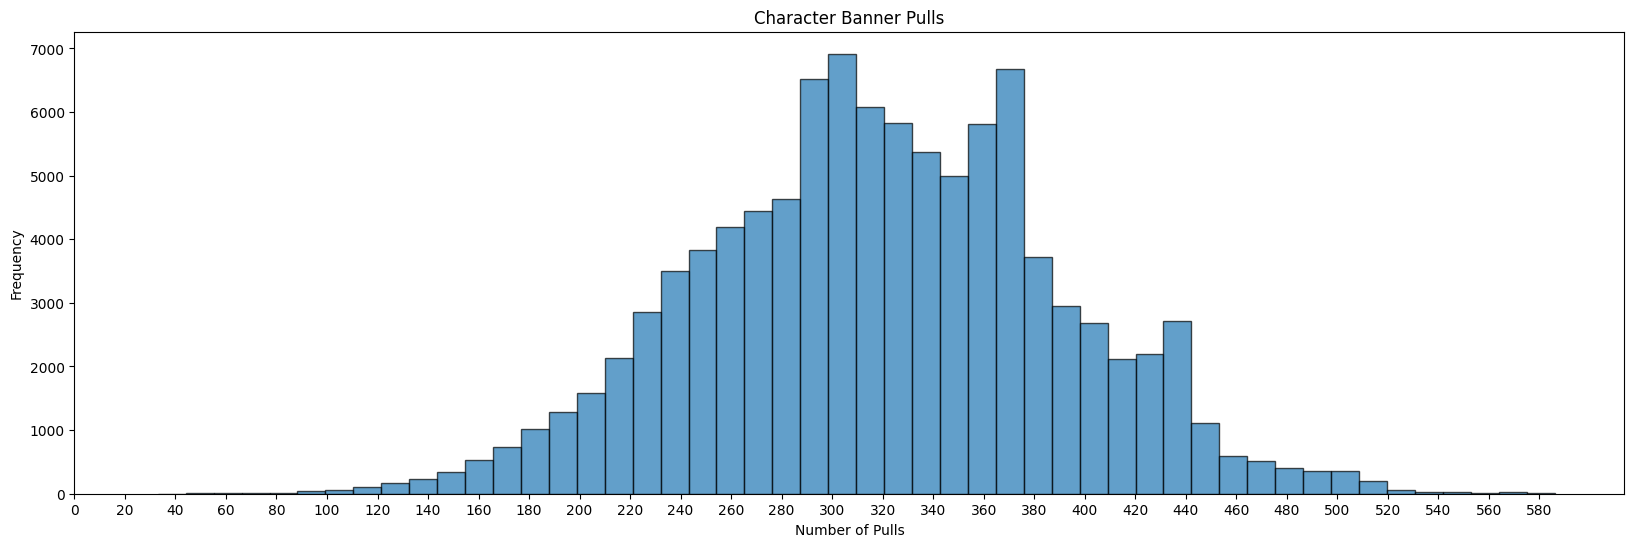

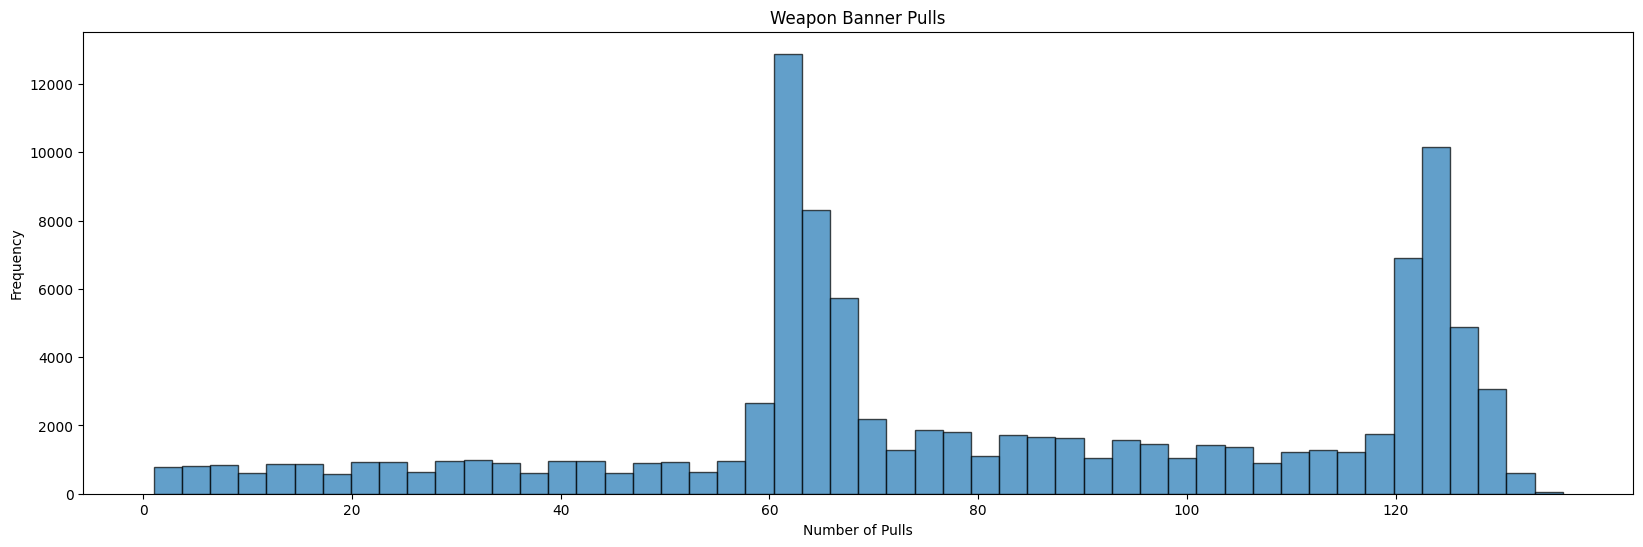

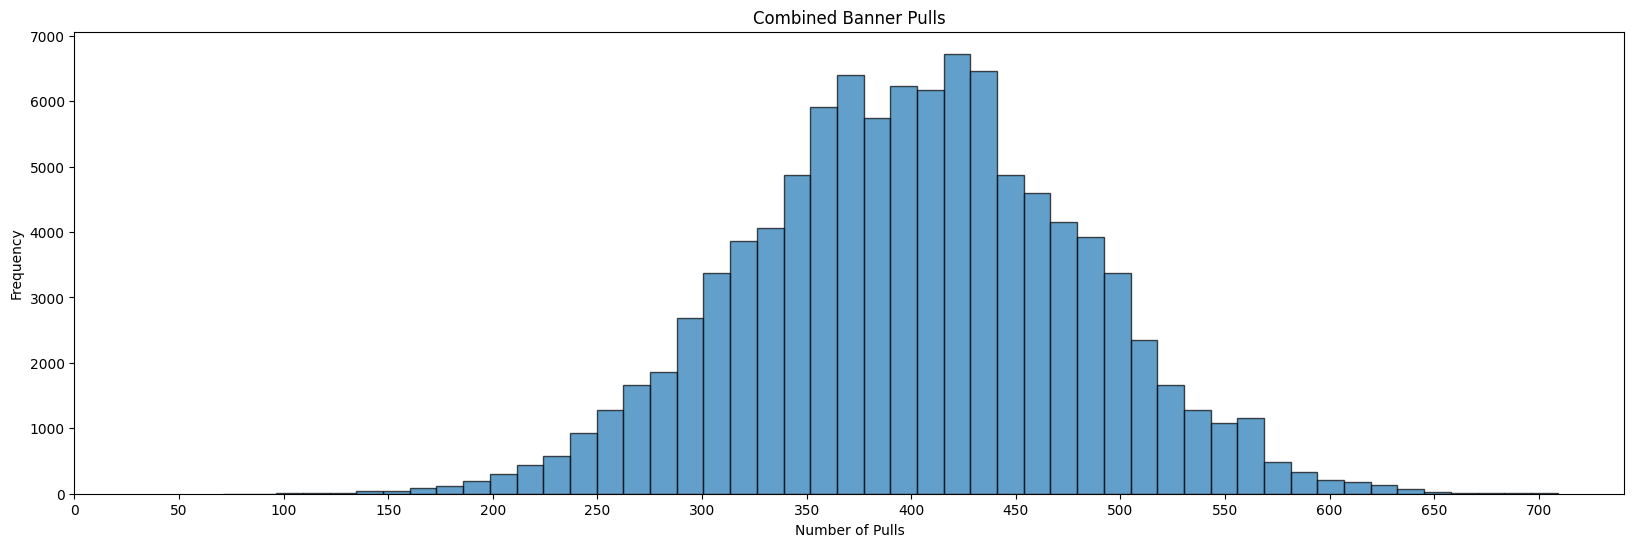

In [ ]:
class CombinedBanner:
    def __init__(self,initial_starglitter = 0,initial_radiance=0, number_of_C0=0):
        self.char_banner = CharBanner(initial_radiance=initial_radiance, number_of_C0=number_of_C0) 
        self.weapon_banner = WeaponBanner()
        self.initial_starglitter = initial_starglitter
        self.current_simulation = {
            "total_pull": [],
            "paid_pull": [],
        }

        

    def test_combined_banner_garentee(self, number_of_pulls, number_of_5_stars_char, number_of_5_stars_weapon, use_starglitter=False):
        for _ in tqdm(range(number_of_pulls), desc="Pulling for 5-star item"):
            total_paid_pull_weapon = 0
            total_paid_pull_char = 0
            total_char_pull = 0
            total_weapon_pull = 0
            self.weapon_banner.starglitter = self.initial_starglitter
            if number_of_5_stars_weapon > 0:
                self.weapon_banner.pull_until_wanted_5_star(number_of_5_stars_weapon, use_starglitter)
                total_paid_pull_weapon += self.weapon_banner.paid_pull
                total_weapon_pull += self.weapon_banner.total_pull
     
            self.char_banner.starglitter = self.weapon_banner.starglitter
            if number_of_5_stars_char > 0:
                self.char_banner.pull_until_wanted_5_star(number_of_5_stars_char, use_starglitter)
                total_paid_pull_char += self.char_banner.paid_pull
                total_char_pull += self.char_banner.total_pull
            self.current_simulation["total_pull"].append(total_weapon_pull + total_char_pull)
            self.current_simulation["paid_pull"].append(total_paid_pull_weapon + total_paid_pull_char)
        return self.get_paid_pull_combined()
    
    def reset_simulation(self):
        self.current_simulation = {
            "total_pull": [],
            "paid_pull": [],
        }
    
    def get_paid_pull_char(self):
        return self.char_banner.current_simulation["paid_pull"]
    
    def get_paid_pull_weapon(self):
        return self.weapon_banner.current_simulation["paid_pull"]
    
    def get_paid_pull_combined(self):
        return self.current_simulation["paid_pull"]
    
    def get_total_pull_char(self):
        return self.char_banner.current_simulation["total_pull"]
    
    def get_total_pull_weapon(self):
        return self.weapon_banner.current_simulation["total_pull"]
    
    def get_total_pull_combined(self):
        return self.current_simulation["total_pull"]
    
    def plot1(self):
        if len(self.get_paid_pull_char()) > 0:
            plot_histogram(
                self.get_paid_pull_char(),
                title="Character Banner Pulls",
                xlabel="Number of Pulls",
                ylabel="Frequency",
                bins=50,
                step=20,
            )
        if len(self.get_paid_pull_weapon()) > 0:
            plot_histogram(
                self.get_paid_pull_weapon(),
                title="Weapon Banner Pulls",
                xlabel="Number of Pulls",
                ylabel="Frequency",
                bins=50,
                step=20,
            )
        if len(self.get_paid_pull_combined()) > 0:
            plot_histogram(
                self.get_paid_pull_combined(),
                title="Combined Banner Pulls",
                xlabel="Number of Pulls",
                ylabel="Frequency",
                bins=50,
                step=50,
            )
            
    def plot_pull_saved(self):
        if len(self.get_paid_pull_char()) > 0:
            tmp = np.array(self.get_total_pull_char()) - np.array(self.get_paid_pull_char())
            plot_histogram(
                tmp,
                title="Character Banner Saved Pulls",
                xlabel="Number of Pulls",
                ylabel="Frequency",
                bins=max(tmp),
                step=1,
            )
        if len(self.get_paid_pull_weapon()) > 0:
            tmp = np.array(self.get_total_pull_weapon()) - np.array(self.get_paid_pull_weapon())
            plot_histogram(
                tmp,
                title="Weapon Banner Saved Pulls",
                xlabel="Number of Pulls",
                ylabel="Frequency",
                bins=max(tmp),
                step=1,
            )
        if len(self.get_paid_pull_combined()) > 0:
            tmp = np.array(self.get_total_pull_combined()) - np.array(self.get_paid_pull_combined())
            plot_histogram(
                tmp,
                title="Combined Banner Saved Pulls",
                xlabel="Number of Pulls",
                ylabel="Frequency",
                bins=max(tmp),
                step=1,
            )

    
    @staticmethod
    def _calc_and_plot(data, title, step):
        max_value = max(data)
        cumulative_percent = [
            sum(d <= xi for d in data) / len(data) * 100 for xi in range(max_value + 1)
        ]
        print(cumulative_percent)
        plot_curve(
            cumulative_percent,
            title="Try Pull Success Rate for " + title + " Banner",
            xlabel="Starting Pull Count",
            ylabel="Success Rate",
            figsize=(20, 6),
            grid=True,
            step=step,
        )
    def plot2(self):
        if len(self.get_paid_pull_char()) > 0:
            self._calc_and_plot(
                self.get_paid_pull_char(),
                "Character",
                20,
            )
        if len(self.get_paid_pull_weapon()) > 0:
            self._calc_and_plot(
                self.get_paid_pull_weapon(),
                "Weapon",
                20,
            )
        if len(self.get_paid_pull_combined()) > 0:
            self._calc_and_plot(
                self.get_paid_pull_combined()
                ,
                "Combined",
                50,
            )
    def plot_4_star(self):
        if len(self.char_banner.res_4_star[0]) > 0:
            plot_histogram(
                self.char_banner.res_4_star[0],
                title="4-Star Character 1 Pulls",
                xlabel="Number of Pulls",
                ylabel="Frequency",
                bins=max(self.char_banner.res_4_star[0]),
                step=1,
            )
        if len(self.char_banner.res_4_star[1]) > 0:
            plot_histogram(
                self.char_banner.res_4_star[1],
                title="4-Star Character 2 Pulls",
                xlabel="Number of Pulls",
                ylabel="Frequency",
                bins=max(self.char_banner.res_4_star[1]),
                step=1,
            )
        if len(self.char_banner.res_4_star[2]) > 0:
            plot_histogram(
                self.char_banner.res_4_star[2],
                title="4-Star Character 3 Pulls",
                xlabel="Number of Pulls",
                ylabel="Frequency",
                bins=max(self.char_banner.res_4_star[2]),
                step=1,
            )
        total_4_star = np.array(self.char_banner.res_4_star[0]) + np.array(self.char_banner.res_4_star[1]) + np.array(self.char_banner.res_4_star[2])
        if len(total_4_star) > 0:
            plot_histogram(
                total_4_star,
                title="Combined 4-Star Characters Pulls",
                xlabel="Number of Pulls",
                ylabel="Frequency",
                bins=max(total_4_star),
                step=1,
            )
        
        if len(self.char_banner.res_4_star[0]) > 0:
            plot_scatter(self.get_total_pull_char(), self.char_banner.res_4_star[0],7, title="Total Pulls vs Total 4-Star Characters Pulled", xlabel="Total 4-Star Characters Pulled", ylabel="Total Pulls")
        if len(self.char_banner.res_4_star[1]) > 0:
            plot_scatter(self.get_total_pull_char(), self.char_banner.res_4_star[1],7, title="Total Pulls vs Total 4-Star Characters Pulled", xlabel="Total 4-Star Characters Pulled", ylabel="Total Pulls")
        if len(self.char_banner.res_4_star[2]) > 0:
            plot_scatter(self.get_total_pull_char(), self.char_banner.res_4_star[2],7, title="Total Pulls vs Total 4-Star Characters Pulled", xlabel="Total 4-Star Characters Pulled", ylabel="Total Pulls")
        if len(total_4_star) > 0:
            plot_scatter(self.get_total_pull_char(), total_4_star, title="Total Pulls vs Total 4-Star Characters Pulled", xlabel="Total 4-Star Characters Pulled", ylabel="Total Pulls")


NUMBER_OF_5_STARS_CHAR = 4
NUMBER_OF_5_STARS_WEAPON = 1
INITIAL_STARGLITTER = 42
INITIAL_RADIANCE = 2
NUMBER_OF_C0 = 2


USE_STARGLITTER = True

number_of_pulls = 100_000


combined = CombinedBanner(initial_starglitter=INITIAL_STARGLITTER, initial_radiance=INITIAL_RADIANCE, number_of_C0=NUMBER_OF_C0)
combined.test_combined_banner_garentee(
    number_of_pulls=number_of_pulls,
    number_of_5_stars_char=NUMBER_OF_5_STARS_CHAR,
    number_of_5_stars_weapon=NUMBER_OF_5_STARS_WEAPON,
    use_starglitter=USE_STARGLITTER,
)
combined.plot1()





[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.002, 0.002, 0.002, 0.002, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.004, 0.005, 0.006, 0.006, 0.006999999999999999, 0.006999999999999999, 0.006999999999999999, 0.006999999999999999, 0.008, 0.009000000000000001, 0.009000000000000001, 0.01, 0.011000000000000001, 0.012, 0.012, 0.012, 0.013, 0.015, 0.015, 0.017, 0.017, 0.017, 0.018000000000000002, 0.019, 0.019, 0.02, 0.02, 0.02, 0.021, 0.025, 0.027999999999999997, 0.03, 0.03, 0.03, 0.031, 0.032, 0.034, 0.036000000000000004, 0.038, 0.04, 0.042, 0.043, 0.048, 0.052, 0.053, 0.055999999999999994, 0.063, 0.066, 0.06899999999999999, 0.073, 0.079, 0.08099999999999999, 0.08499999999999999, 0.08499999999999999, 0.095, 0.10300000000000001, 0.108, 0.11299999999999999, 0.121, 0.126, 0.131, 0.133, 0.136, 0.14200000000000002, 0.15, 0.159, 0.1709

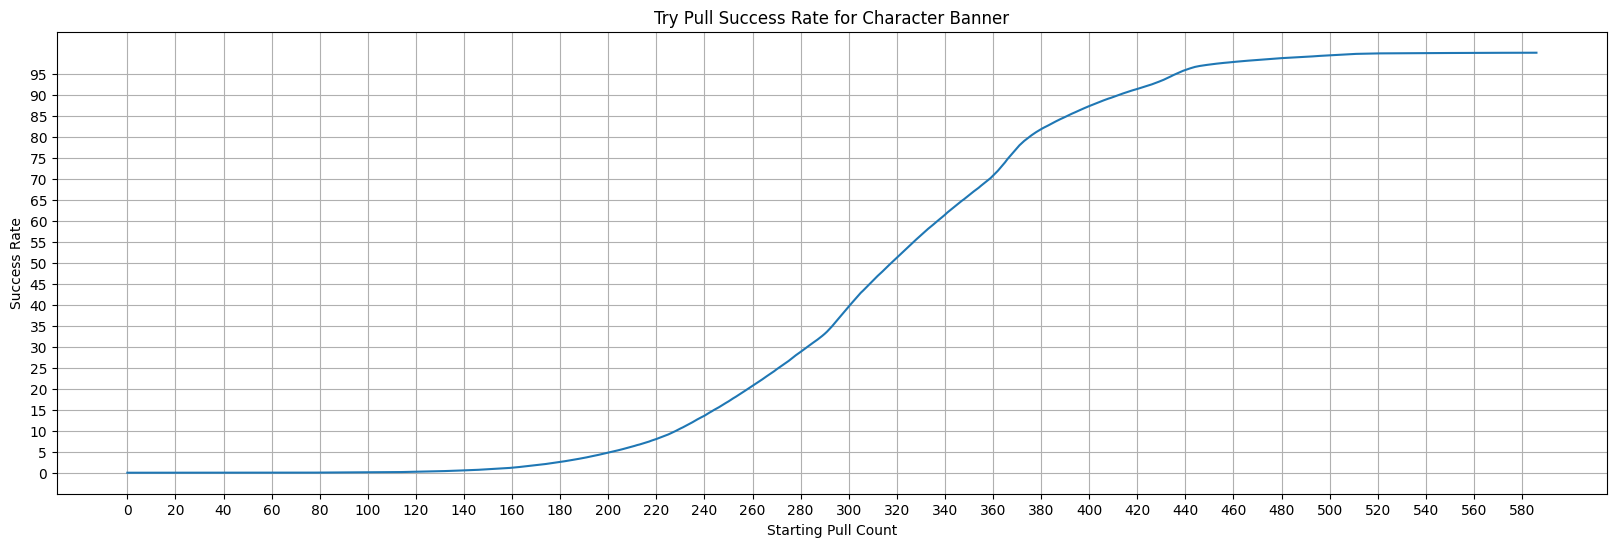

[0.0, 0.259, 0.528, 0.768, 1.027, 1.316, 1.5859999999999999, 1.8780000000000001, 2.157, 2.439, 2.734, 3.039, 3.331, 3.624, 3.9190000000000005, 4.208, 4.504, 4.803, 5.0889999999999995, 5.390000000000001, 5.734999999999999, 6.029, 6.331, 6.605999999999999, 6.922000000000001, 7.256, 7.588, 7.879, 8.198, 8.519, 8.823, 9.135, 9.49, 9.799, 10.09, 10.412, 10.709, 11.020000000000001, 11.322000000000001, 11.645, 11.962, 12.273, 12.601999999999999, 12.912, 13.224, 13.533999999999999, 13.844999999999999, 14.122000000000002, 14.435, 14.735000000000001, 15.049000000000001, 15.351999999999999, 15.665000000000001, 15.979, 16.288, 16.603, 16.927, 17.236, 17.573, 18.163999999999998, 19.907, 23.227999999999998, 27.866000000000003, 32.792, 37.458000000000006, 41.109, 43.817, 45.595, 46.836, 47.674, 48.373, 49.023, 49.664, 50.312999999999995, 50.929, 51.568000000000005, 52.190000000000005, 52.773, 53.383, 54.00899999999999, 54.567, 55.108999999999995, 55.691, 56.299, 56.821999999999996, 57.365, 57.9169999

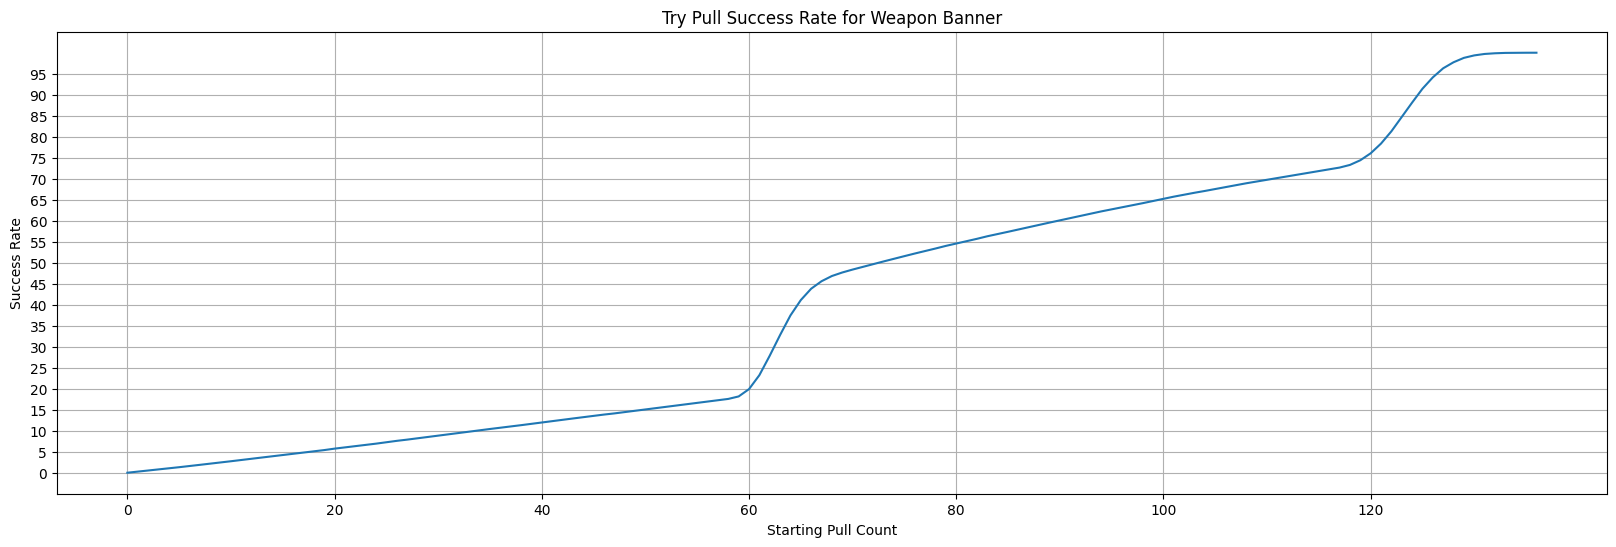

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.004, 0.004, 0.004, 0.004, 0.004, 0.004, 0.006, 0.006999999999999999, 0.006999999999999999, 0.006999999999999999, 0.006999999999999999, 0.009000000000000001, 0.009000000000000001, 0.009000000000000001, 0.009000000000000001, 0.013, 0.013999999999999999, 0.017, 0.017, 0.017, 0.018000000000000002, 0.02, 0.02, 0.021, 0.021, 0.021, 0.022000000000000002, 0.023, 0.025, 0.025, 0.027999999999999997, 0.03, 0.032, 0.034999999999999996, 0.037, 0.03

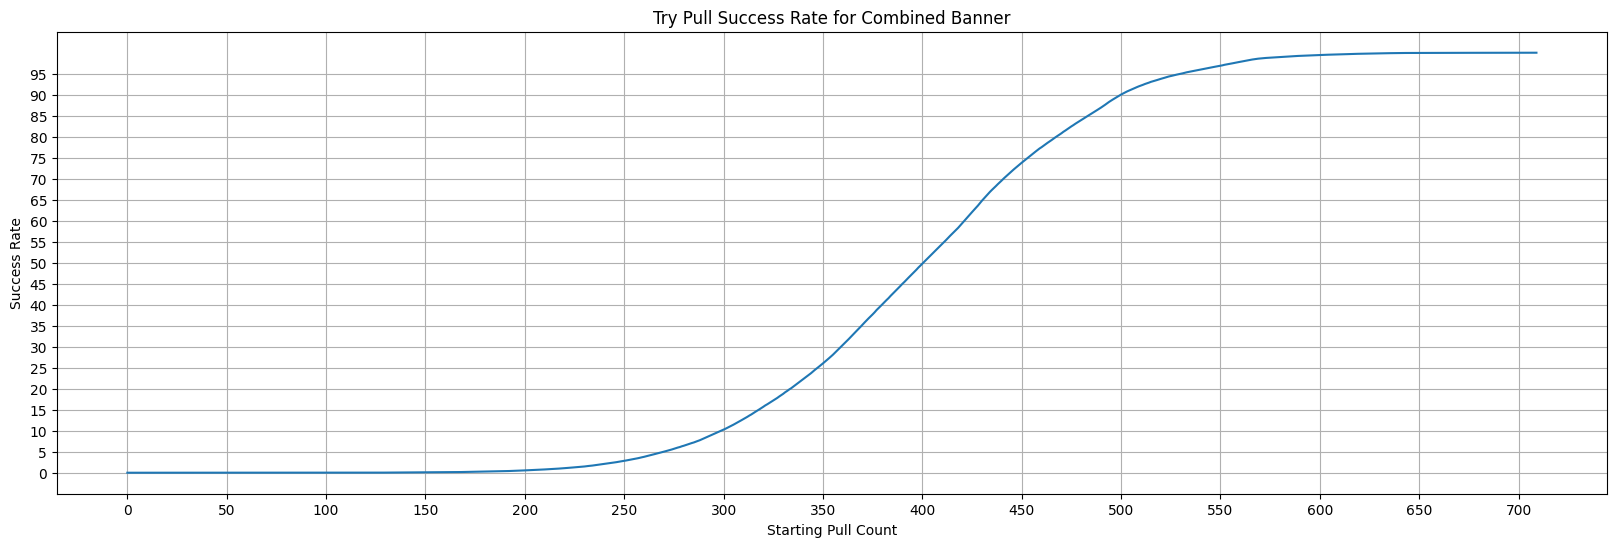

In [458]:
combined.plot2()


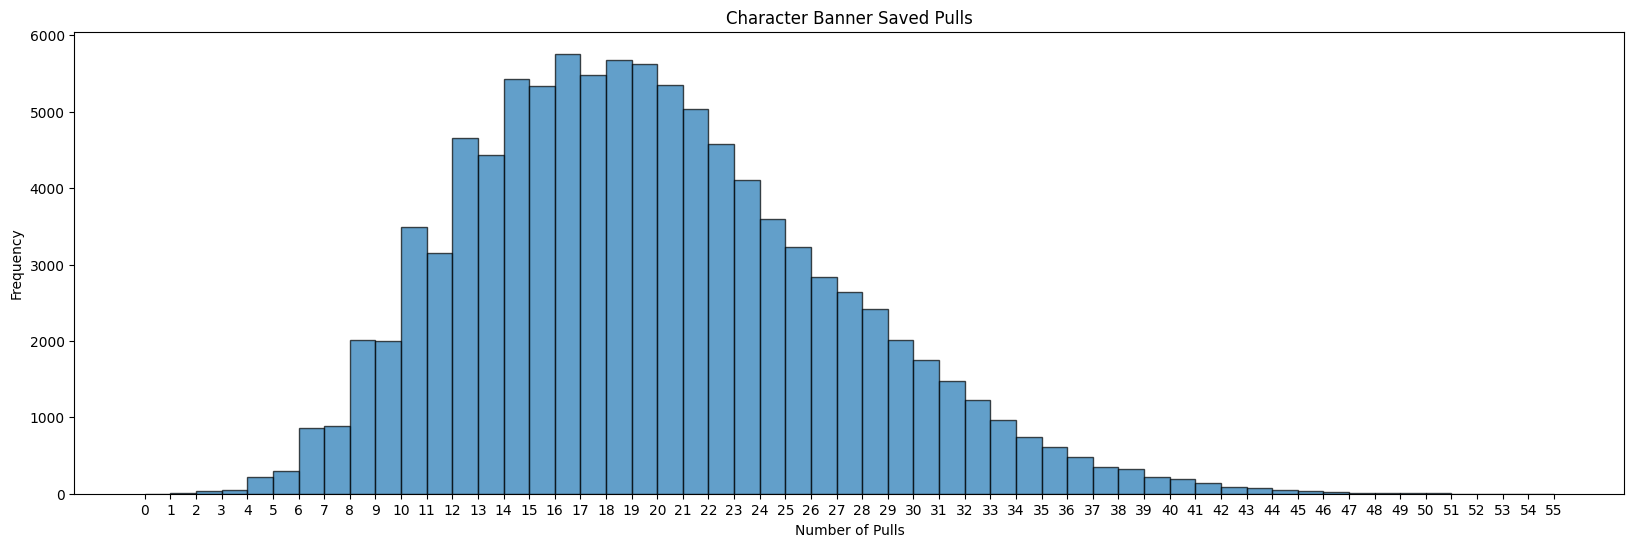

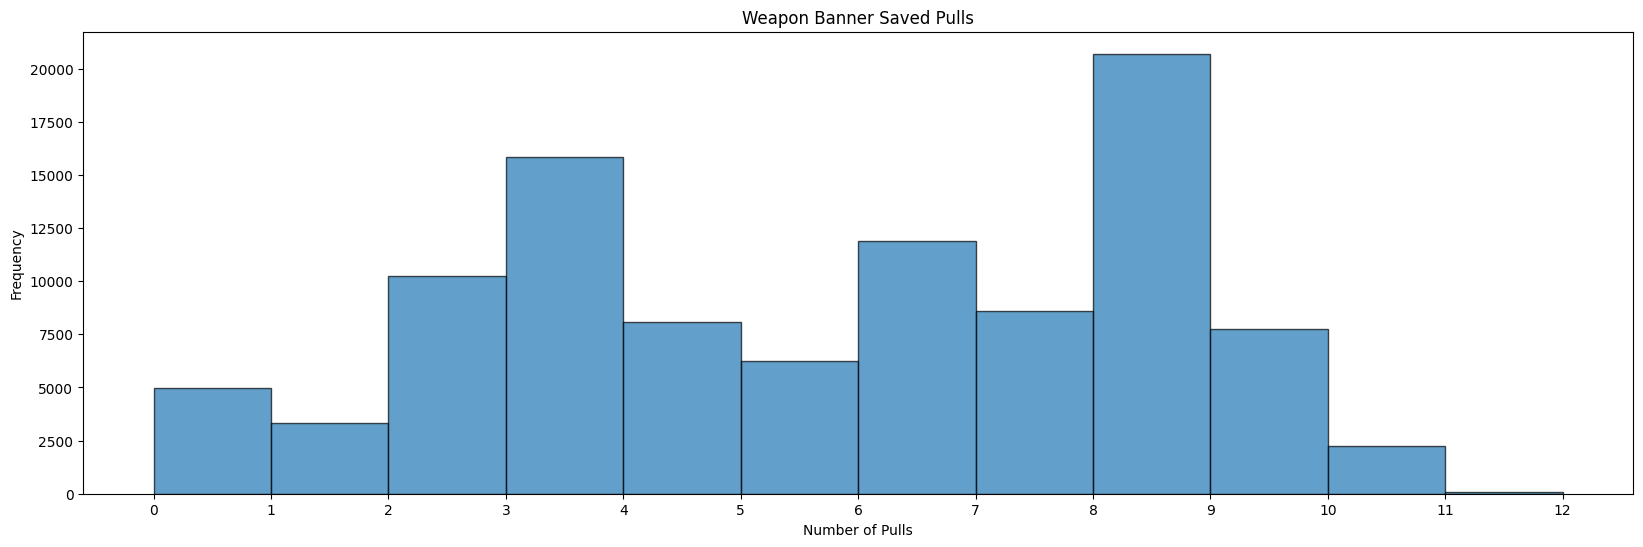

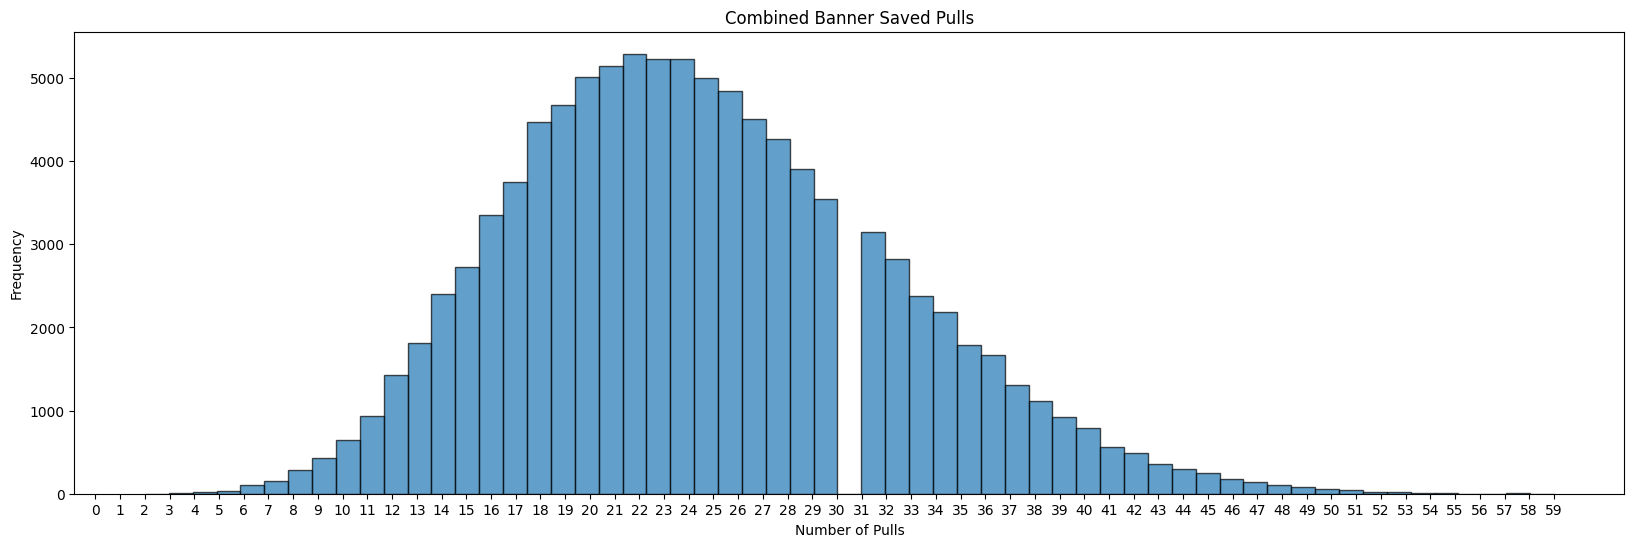

In [459]:
combined.plot_pull_saved()

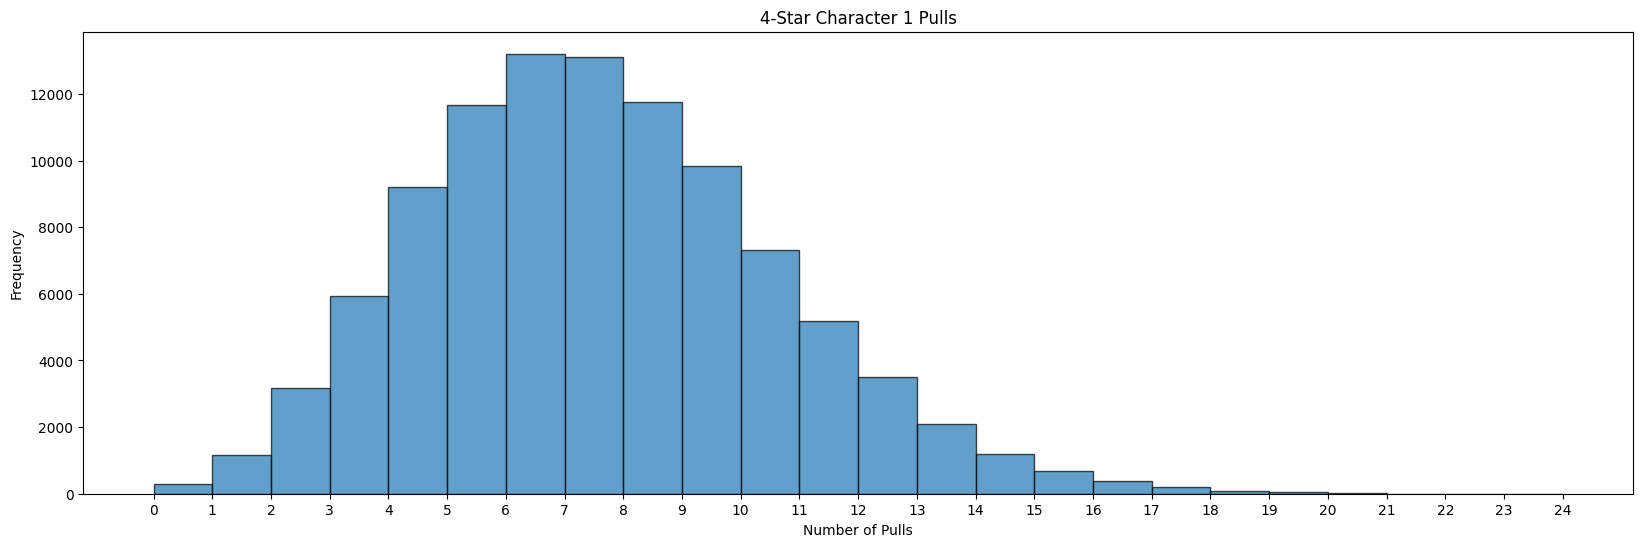

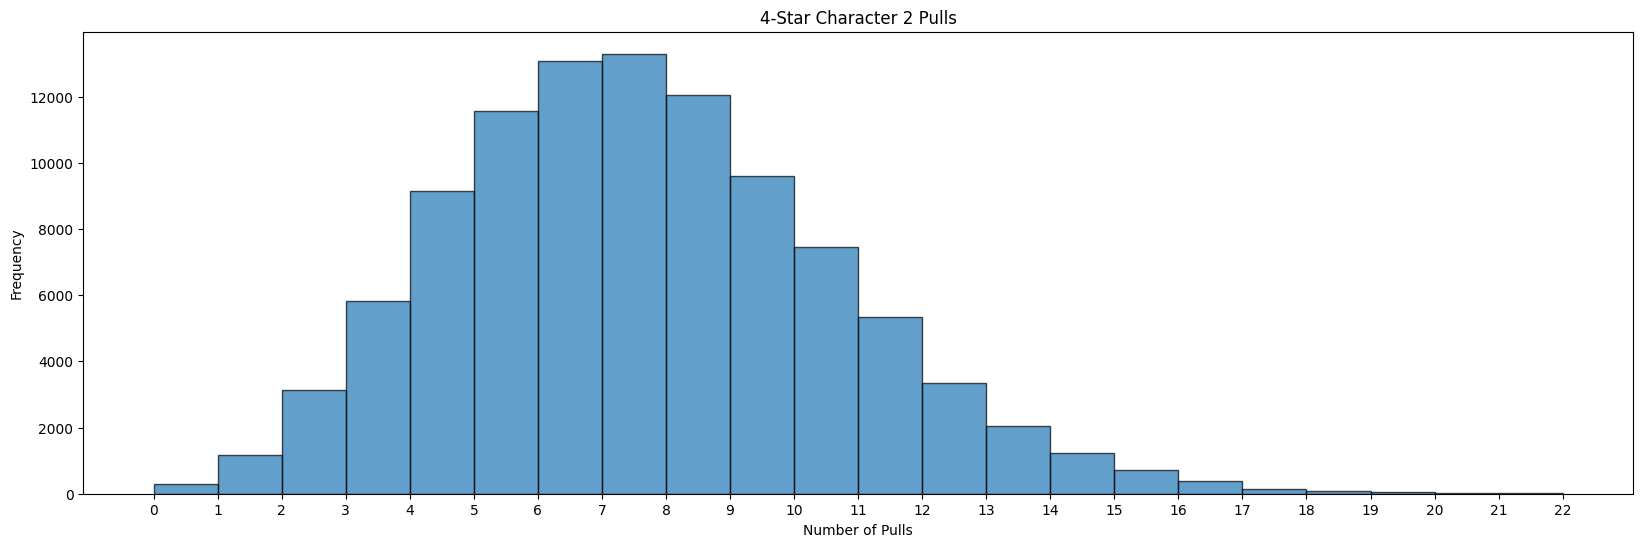

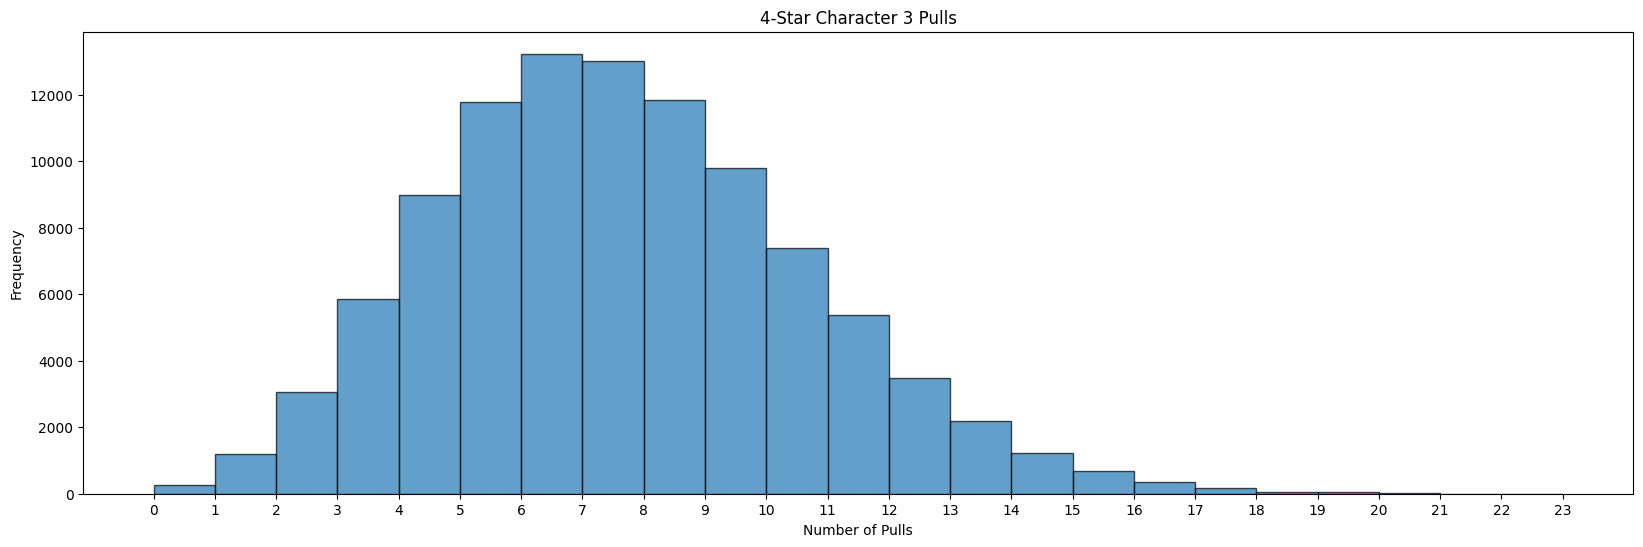

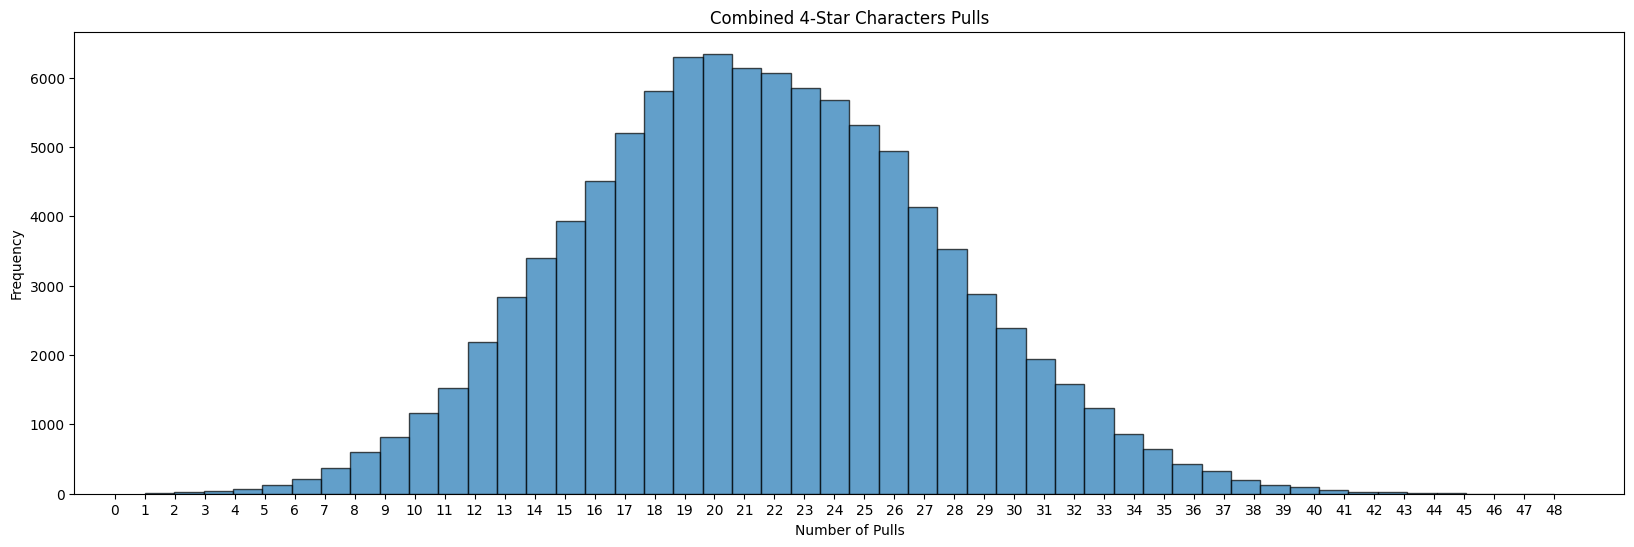

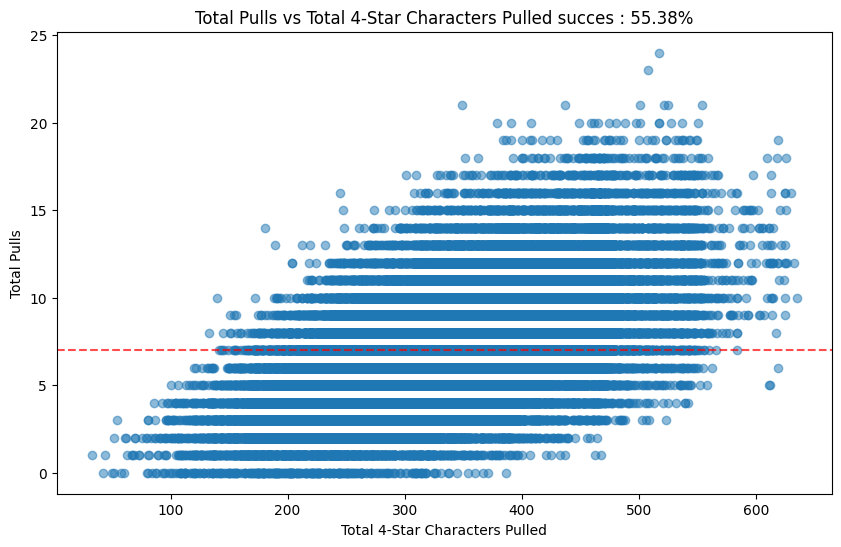

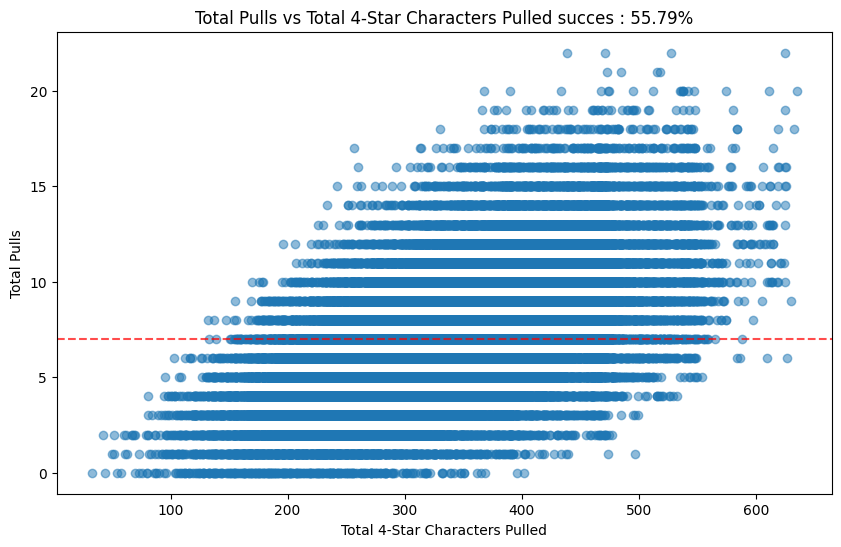

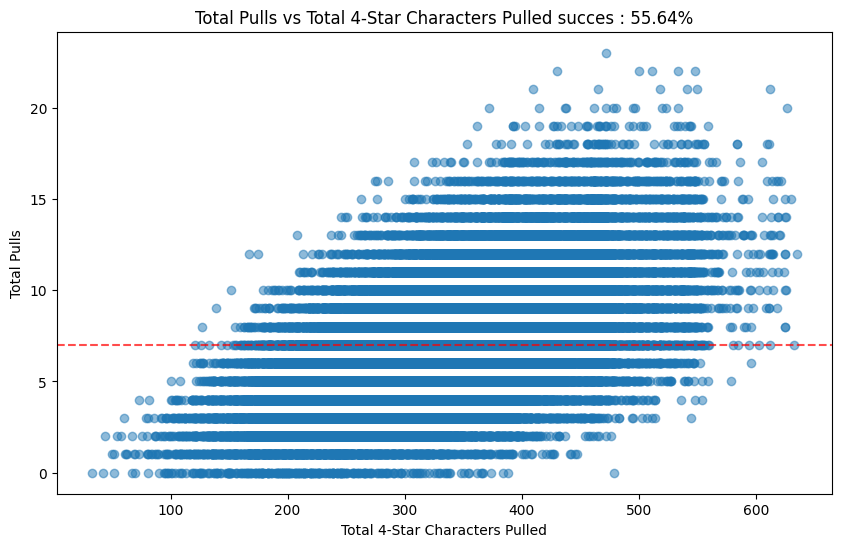

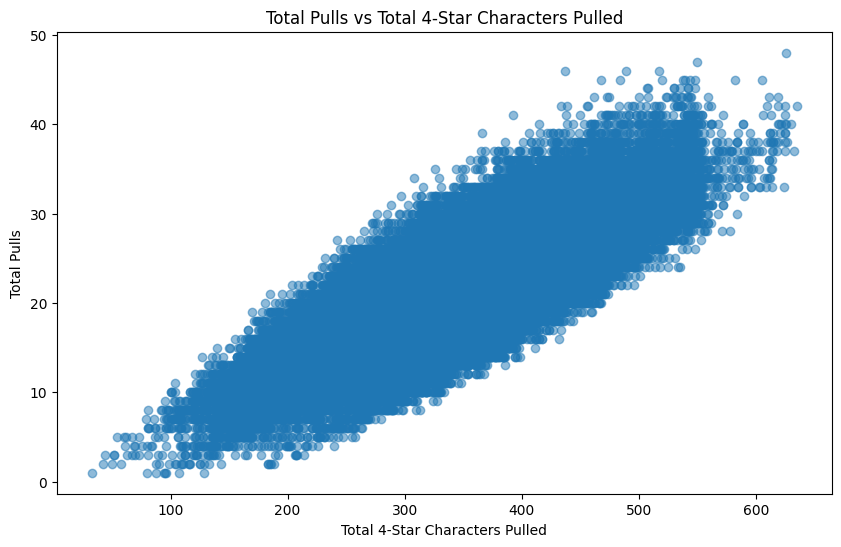

In [460]:
combined.plot_4_star()

In [461]:
testing_purpose = False

if testing_purpose:
    ref_power = 2

    power_of_ten_list = [10**i for i in range(ref_power)]

    ref = char_banner.test_banner_garentee(10**ref_power)

    cumulative_percent_ref = [0] * 180

    for i in range(180):

        cumulative_percent_ref[i] = sum(d <= i for d in ref) / len(ref) * 100

    for pulls in power_of_ten_list:

        test = char_banner.test_banner_garentee(pulls)

        cumulative_percent_test = [0] * 180

        for i in range(180):

            cumulative_percent_test[i] = sum(d <= i for d in test) / len(test) * 100

        diff_sum = sum(
            abs(a - b) for a, b in zip(cumulative_percent_test, cumulative_percent_ref)
        )

        print(f"Difference for {pulls} pulls: {diff_sum}")